In [45]:
import sys
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
import math as m
import argparse
from astropy.cosmology import FlatLambdaCDM
from matplotlib.backends.backend_pdf import PdfPages
import kcorrect
import kcorrect.utils as ut
import os
import pandas as pd

python Luminosity_Function.py /Users/lucashunt/ASTRODATA/LCBG_LUMINOSITY_FUNCTION/COSMOS_CATALOGS/Final_Catalogs/Laigle_LCBG_Catalog.csv -mbin 18 -zmin 0.01 -zmax 0.2 -mmin -24 -mmax -15 -ama 23 -ami 15 -om 0.3 -ho 70

In [46]:
parser = argparse.ArgumentParser()
parser.add_argument("filein",help="File containing magnitudes and redshifts")
parser.add_argument("-mbin","--mbin",type=int,help="Number of Absolute Magnitude bins. Default=19",default=18)
parser.add_argument("-zmin","--zmin",type=float,help="Minimum redshift to consider in luminosity function, default=0.01", default=0.01)
parser.add_argument("-zmax","--zmax",type=float,help="Maximum redshift to consider in luminosity function, default=2", default=0.2)
parser.add_argument("-mmin","--Mmin",type=float,help="Minumum absolute magnitude to consider in luminosity function, default=-24", default=-24)
parser.add_argument("-mmax","--Mmax",type=float,help="Maximum absolute magnitude to consider in luminosity function, default=-15", default=-15)
parser.add_argument("-ama","--appmax",type=float,help='Maximum apparent magnitude to consider part of the survey COSMOS i<22.5',default=22.5)
parser.add_argument("-ami","--appmin",type=float,help='Minimum apparent magnitude to consider part of the survey COSMOS i>15',default=15)
parser.add_argument("-om","--OmegaMatter",type=float,help="Omega Matter, if you want to define your own cosmology", default=0.3)
parser.add_argument("-ho","--HubbleConstant",type=float,help="Hubble Constant if you want to define your own cosmology",default=70)
parser.add_argument("-lfdir","--lfdir",help="Directroy you want to put the Luminosity Function txt file and the underlying catalog in",default='/Users/lucashunt/projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT/')
parser.add_argument("-fileout","--fileout",type=str,help="Set a string if you want to give a filename if not it will default to LF_zmin_zmax.csv",default='')
parser.add_argument("-LCBG","--LCBGLIST",action="store_true",help="Make Luminosity Function with LCBGs only?")
parser.add_argument("-nv","--novega",action="store_true",help="Do not apply correction to switch from AB to Vega magnitudes")
args=parser.parse_args()

usage: ipykernel_launcher.py [-h] [-mbin MBIN] [-zmin ZMIN] [-zmax ZMAX]
                             [-mmin MMIN] [-mmax MMAX] [-ama APPMAX]
                             [-ami APPMIN] [-om OMEGAMATTER]
                             [-ho HUBBLECONSTANT] [-lfdir LFDIR]
                             [-fileout FILEOUT] [-LCBG] [-nv]
                             filein
ipykernel_launcher.py: error: the following arguments are required: filein


SystemExit: 2

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [47]:
#This can be turned to code in a jupyter notebook to set all of the args using argparser. That way you can run the code in the notebook

args=parser.parse_args('/home/lrhunt/Astrodata/LCBG_Luminosity_Function/Original_Catalogs/Final_Catalogs/COSMOS_CONVERTED_CATALOG.csv -zmin 0.01 -zmax 0.2'.split())

Setting values needed throughout the code

In [48]:
cosmo=FlatLambdaCDM(H0=args.HubbleConstant,Om0=args.OmegaMatter)
mbinsize=float(args.Mmax-args.Mmin)/args.mbin
Magnitude_Loop_Array=np.stack((np.arange(15,22.5+0.5,0.5)[0:len(np.arange(15,22.5+0.5,0.5))-1],np.arange(15,22.5+0.5,0.5)[1:len(np.arange(15,22.5+0.5,0.5))]),axis=-1)
kcordir=os.environ["KCORRECT_DIR"]

In [49]:
print('********READING FILE********')
CATALOG=pd.read_csv(args.filein)

********READING FILE********


In [50]:
print('********CALCULATING WEIGHTS********')
tf=open('weights.txt','w')
CATALOG['Spec_Weight']=np.nan
CATALOG['Color_Weight']=np.nan
CATALOG['Surface_Brightness_Weight']=np.nan
for magrange in Magnitude_Loop_Array:
    Num_Good_Spec=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                              (CATALOG.subaru_i_mag<magrange[1])&
                              (CATALOG.SG_MASTER==0)&
                              ((CATALOG.Z_USE==1)|
                               (CATALOG.Z_USE==2))])
    Num_Bad_Spec=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                             (CATALOG.subaru_i_mag<magrange[1])&
                             (CATALOG.SG_MASTER==0)&
                             ((CATALOG.Z_USE==3)|
                              (CATALOG.Z_USE==4))])
    Num_Good_Color=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                               (CATALOG.subaru_i_mag<magrange[1])&
                               (CATALOG.SG_MASTER==0)&
                               ((CATALOG.subaru_B_mag<100)&
                                (CATALOG.subaru_V_mag<100))])
    Num_Bad_Color=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                              (CATALOG.subaru_i_mag<magrange[1])&
                              (CATALOG.SG_MASTER==0)&
                              ((CATALOG.subaru_B_mag>100)|
                               (CATALOG.subaru_V_mag>100))])
    Num_Bad_Rh=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                           (CATALOG.subaru_i_mag<magrange[1])&
                           (CATALOG.SG_MASTER==0)&
                           (np.isnan(CATALOG.R_HALF_PIXELS))])
    Num_Good_Rh=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                            (CATALOG.subaru_i_mag<magrange[1])&
                            (CATALOG.SG_MASTER==0)&
                            (~np.isnan(CATALOG.R_HALF_PIXELS))])
    CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                (CATALOG.subaru_i_mag<magrange[1])&
                (CATALOG.SG_MASTER==0),
                'Spec_Weight']=float(Num_Good_Spec+Num_Bad_Spec)/float(Num_Good_Spec)
    CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                (CATALOG.subaru_i_mag<magrange[1])&
                (CATALOG.SG_MASTER==0),
                'Color_Weight']=float(Num_Good_Color+Num_Bad_Color)/float(Num_Good_Color)
    CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                (CATALOG.subaru_i_mag<magrange[1])&
                (CATALOG.SG_MASTER==0),
                'Surface_Brightness_Weight']=float(Num_Good_Rh+Num_Bad_Rh)/float(Num_Good_Rh)
    print('Spec Weight = {} | Color Weight = {} | Surface Brightness Weight = {}'.format(
        np.round(float(Num_Good_Spec+Num_Bad_Spec)/float(Num_Good_Spec),4),
        np.round(float(Num_Good_Color+Num_Bad_Color)/float(Num_Good_Color),4),
        np.round(float(Num_Good_Rh+Num_Bad_Rh)/float(Num_Good_Rh),4)))

    

********CALCULATING WEIGHTS********
Spec Weight = 5.75 | Color Weight = 1.0 | Surface Brightness Weight = 2.3
Spec Weight = 5.5 | Color Weight = 1.0 | Surface Brightness Weight = 11.0
Spec Weight = 1.1818 | Color Weight = 1.0 | Surface Brightness Weight = 6.5
Spec Weight = 1.0435 | Color Weight = 1.0 | Surface Brightness Weight = 1.3333
Spec Weight = 1.0566 | Color Weight = 1.0 | Surface Brightness Weight = 2.0
Spec Weight = 1.2267 | Color Weight = 1.011 | Surface Brightness Weight = 1.84
Spec Weight = 1.218 | Color Weight = 1.0 | Surface Brightness Weight = 1.4595
Spec Weight = 1.1867 | Color Weight = 1.0 | Surface Brightness Weight = 1.3021
Spec Weight = 1.1932 | Color Weight = 1.0 | Surface Brightness Weight = 1.4015
Spec Weight = 1.2101 | Color Weight = 1.0 | Surface Brightness Weight = 1.33
Spec Weight = 1.2232 | Color Weight = 1.0 | Surface Brightness Weight = 1.2778
Spec Weight = 1.2264 | Color Weight = 1.0 | Surface Brightness Weight = 1.3045
Spec Weight = 1.2818 | Color Weight

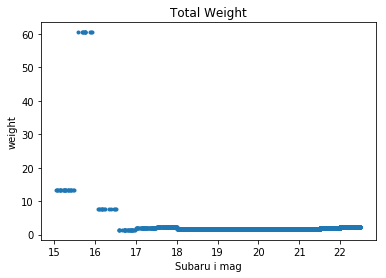

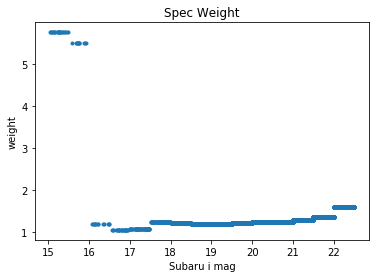

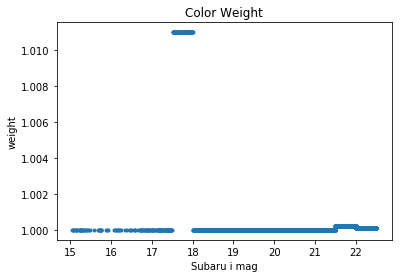

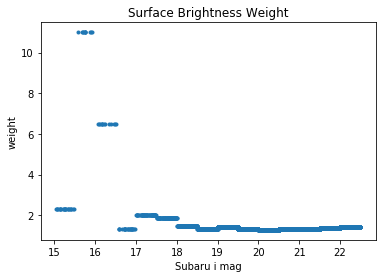

In [56]:
plt.plot(CATALOG.subaru_i_mag,CATALOG.Spec_Weight*CATALOG.Color_Weight*CATALOG.Surface_Brightness_Weight,'.')
plt.title('Total Weight')
plt.xlabel('Subaru i mag')
plt.ylabel('weight')
plt.figure()
plt.plot(CATALOG.subaru_i_mag,CATALOG.Spec_Weight,'.')
plt.title('Spec Weight')
plt.ylabel('weight')
plt.xlabel('Subaru i mag')
plt.figure()
plt.title('Color Weight')
plt.ylabel('weight')
plt.xlabel('Subaru i mag')
plt.plot(CATALOG.subaru_i_mag,CATALOG.Color_Weight,'.')
plt.figure()
plt.title('Surface Brightness Weight')
plt.ylabel('weight')
plt.xlabel('Subaru i mag')
plt.plot(CATALOG.subaru_i_mag,CATALOG.Surface_Brightness_Weight,'.')

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.000e+01, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.390e+02, 1.476e+03, 3.595e+03, 1.989e+03, 7.940e+02, 6.260e+02,
        7.120e+02, 1.301e+03, 1.499e+03, 1.340e+03, 1.681e+03, 1.694e+03,
        1.684e+03, 2.193e+03, 2.373e+03, 2.329e+03, 2.181e+03, 1.793e+03,
        1.932e+03, 2.310e+03, 2.378e+03, 2.123e+03, 1.950e+03, 1.986e+03,
        2.013e+03, 1.971e+03, 1.941e+03, 1.976e+03, 1.833e+03, 1.648e+03,
        1.635e+03, 1.636e+03, 1.709e+03, 1.584e+03, 1.506e+03, 1.323e+03,
        1.364e+03, 1.382e+03, 1.305e+03, 1.273e+03, 1.224e+03, 1.175e+03,
        1.102e+03, 1.000e+03, 1.037e+03, 1.058e+03, 1.040e+03, 9.210e+02,
        8.730e+02, 9.100e+02, 8.970e+02, 8.980e+02, 8.150e+02, 6.890e+02,
        7.330e+02, 6.710e+02, 6.680e+02, 6.810e+02, 6.590e+02, 6.830e+02,
        5.710e+02, 5.650e+02, 5.640e+02, 5.410e+02, 5.140e+02, 4.730e+02,
        4.790e+02, 5.080e+02, 4.460e+0

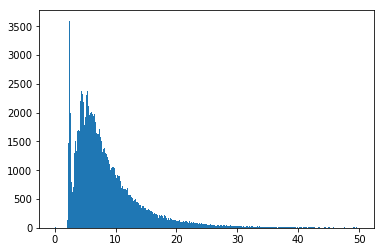

In [57]:
plt.hist(CATALOG.R_HALF_PIXELS,range=[0,50],bins=300)

In [60]:
CATALOG['BJ0_vega_surfacebrightness_noRcorr']=\
(CATALOG['BJ0_vega_absmag']+
 2.5*np.log10(
     2*np.pi*
     np.power(1/cosmo.arcsec_per_kpc_proper(CATALOG.Z_BEST.values).value*
              (
                  (
                      CATALOG.R_HALF_PIXELS.values*
                      0.03
                  )
              )
              ,2)
 )
 +2.5*np.log10((360*60*60/(2*np.pi*0.01))**2))

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1922: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


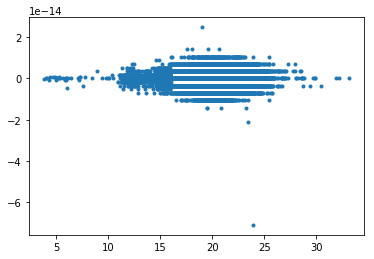

In [69]:
plt.plot(CATALOG['BJ0_vega_surfacebrightness_noRcorr'],
         (CATALOG['BJ0_vega_surface_brightness']-CATALOG['BJ0_vega_surfacebrightness_noRcorr']),marker='.',linestyle='')

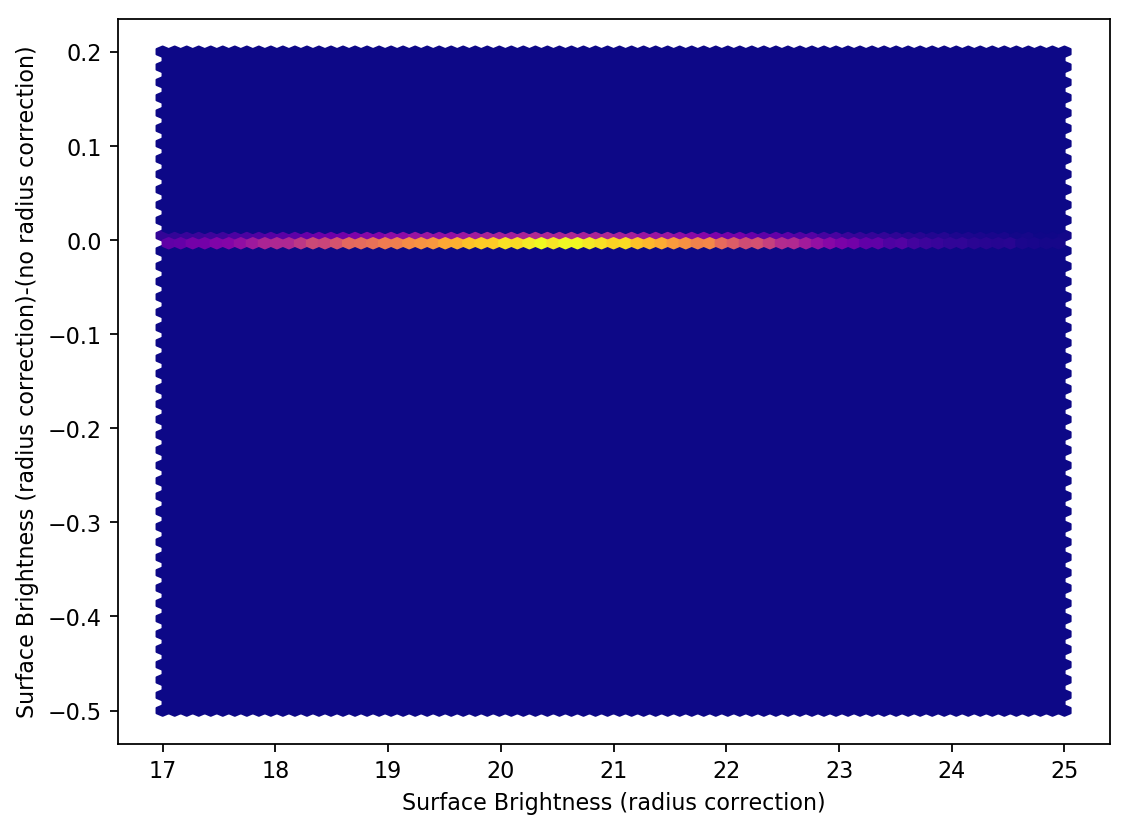

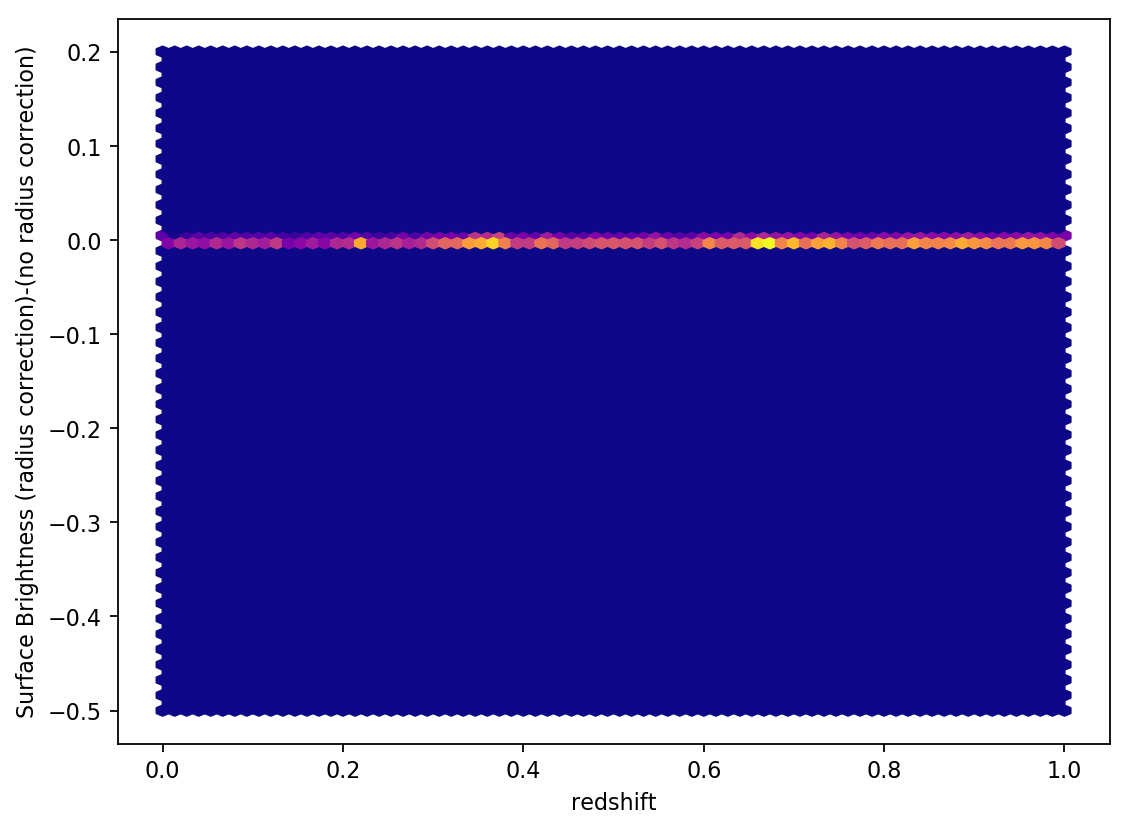

In [64]:
plt.figure(figsize=(8,6),dpi=160)
plt.hexbin(CATALOG['BJ0_vega_surface_brightness'],
         (CATALOG['BJ0_vega_surface_brightness']-CATALOG['BJ0_vega_surfacebrightness_noRcorr']),
          gridsize=75,cmap='plasma',extent=[17,25,-0.5,0.2])
plt.ylabel('Surface Brightness (radius correction)-(no radius correction)')
plt.xlabel('Surface Brightness (radius correction)')
plt.savefig('Radius_Correction_SB_dif.png')
plt.figure(figsize=(8,6),dpi=160)
plt.hexbin(CATALOG['Z_BEST'],
         (CATALOG['BJ0_vega_surface_brightness']-CATALOG['BJ0_vega_surfacebrightness_noRcorr']),
          gridsize=75,cmap='plasma',extent=[0,1,-0.5,0.2])
plt.ylabel('Surface Brightness (radius correction)-(no radius correction)')
plt.xlabel('redshift')
plt.savefig('Radius_Correction_SB_dif_redshift.png')

In [30]:
CATALOG['Rcorr_LCBG']=0
CATALOG['noRcorr_LCBG']=0
CATALOG.loc[(CATALOG.BJ0_vega_absmag.values<-18.5)&
            (CATALOG.BJ0_vega_surfacebrightness_Rcorr.values<21)&
            (CATALOG['rest_frame_B-V'].values<0.6),
            'Rcorr_LCBG']=1
CATALOG.loc[(CATALOG.BJ0_vega_absmag.values<-18.5)&
            (CATALOG.BJ0_vega_surfacebrightness_noRcorr.values<21)&
            (CATALOG['rest_frame_B-V'].values<0.6),
            'noRcorr_LCBG']=1

/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [37]:
print(len(CATALOG.loc[(CATALOG.Z_USE<3)&(CATALOG.Rcorr_LCBG==1)&(CATALOG.Z_BEST<1)&(CATALOG.SG_MASTER==0)]))
(len(CATALOG.loc[(CATALOG.Z_USE<3)&(CATALOG.noRcorr_LCBG==1)&(CATALOG.Z_BEST<1)&(CATALOG.SG_MASTER==0)]))

4086


4207

***********************************
Starting the Luminosity Function part of the code! 
***********************************

Breaking up the large catalog into a smaller one containing the sources over the correct redshift range and apparent magnitude range

In [7]:
print('********LOOKING FOR LCBGS********')
if args.LCBGLIST:
    LUMFUNC_CATALOG=CATALOG.loc[(CATALOG.Z_USE<3)&
                            (CATALOG.subaru_i_mag<=args.appmax)&
                            (CATALOG.subaru_i_mag>=args.appmin)&
                            (CATALOG.SG_MASTER==0)&
                            (CATALOG.Z_BEST>=args.zmin)&
                            (CATALOG.Z_BEST<=args.zmax)&
                            (CATALOG.is_LCBG==1)]
else:
    LUMFUNC_CATALOG=CATALOG.loc[(CATALOG.Z_USE<3)&
                            (CATALOG.subaru_i_mag<=args.appmax)&
                            (CATALOG.subaru_i_mag>=args.appmin)&
                            (CATALOG.SG_MASTER==0)&
                            (CATALOG.Z_BEST>=args.zmin)&
                            (CATALOG.Z_BEST<=args.zmax)]

Setting apparent magnitude limits to calculate the range over which this source would be detected. 

In [43]:
print('********FINDING UPPER AND LOWER REDSHIFTS********')
kcorrect.load_templates()
kcorrect.load_filters(kcordir+'/data/templates/subaru_i.dat')
zlookup=np.linspace(0,1,1000)
for x in LUMFUNC_CATALOG.index:
    rmarrlookup=np.ndarray(1000)
    for j in range(0,1000):
        rmarrlookup[j]=kcorrect.reconstruct_maggies(LUMFUNC_CATALOG.loc[x,'c1':'c6'],redshift=zlookup[j])[1:]
    AbsMag=LUMFUNC_CATALOG.subaru_i_mag.loc[x]-cosmo.distmod(LUMFUNC_CATALOG.Z_BEST.loc[x]).value-LUMFUNC_CATALOG.subaru_i_synthetic_mag.loc[x]-2.5*np.log10(rmarrlookup[0])
    ilookup=AbsMag+cosmo.distmod(zlookup).value-2.5*np.log10(rmarrlookup)+2.5*np.log10(rmarrlookup[0])
    LUMFUNC_CATALOG.loc[x,'upper_redshift']=round(zlookup[np.abs(ilookup-args.appmax).argmin()],4)
    LUMFUNC_CATALOG.loc[x,'lower_redshift']=round(zlookup[np.abs(ilookup-args.appmin).argmin()],4)

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [48]:
LUMFUNC_CATALOG.loc[LUMFUNC_CATALOG.upper_redshift>args.zmax,'upper_redshift']=args.zmax
LUMFUNC_CATALOG.loc[LUMFUNC_CATALOG.lower_redshift<args.zmin,'lower_redshift']=args.zmin
LUMFUNC_CATALOG['comoving_volume']=cosmo.comoving_volume(LUMFUNC_CATALOG.upper_redshift).value/(4*np.pi/0.0003116)-cosmo.comoving_volume(LUMFUNC_CATALOG.lower_redshift).value/(4*np.pi/0.0003116)

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [49]:
print('********CALCULATING VALUES FOR LUMINOSITY FUNCTION********')
Abs_Magnitude_Loop_Array=np.stack((np.arange(args.Mmin,args.Mmax+mbinsize,mbinsize)[0:len(np.arange(args.Mmin,args.Mmax,mbinsize))],np.arange(args.Mmin,args.Mmax+mbinsize,mbinsize)[1:len(np.arange(args.Mmin,args.Mmax,mbinsize))+1]),axis=-1)
Abs_Mags=[]
NUMB_DENS_LIST=[]
NUMB_DENS_Err=[]
NGal=[]
AveCMV=[]
AveWeight=[]
for rng in Abs_Magnitude_Loop_Array:
    if args.LCBGLIST:
        NUMB_DENS_LIST.append(((
            LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                'Spec_Weight']
            *LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                'Color_Weight']
            *LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                'Surface_Brightness_Weight'])
            /(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                  (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                  'comoving_volume']*mbinsize)).sum())
        AveWeight.append(((
            LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                'Spec_Weight']
            *LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                 (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                 'Color_Weight']
            *LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                 (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                 'Surface_Brightness_Weight']).sum()
            /len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                     (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                     'Spec_Weight'])))
        NUMB_DENS_Err.append(
            np.sqrt(
                (
                    (LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                         (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                         'Spec_Weight']*
                     LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                         (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                         'Color_Weight']*
                     LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                         (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                         'Surface_Brightness_Weight'])
                    /(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                          (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1])
                                          ,'comoving_volume']*mbinsize)**2).sum()))
    else:
        NUMB_DENS_LIST.append(
            (LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                 (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                 'Spec_Weight']
             /(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                   (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                   'comoving_volume']*
               mbinsize)).sum())
        NUMB_DENS_Err.append(np.sqrt(
            (LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                 (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                 'Spec_Weight']
             /(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                   (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                   'comoving_volume']
               *mbinsize)**2).sum()))
        AveWeight.append(
            LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                             (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                'Spec_Weight'].sum()/
            len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                    (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                    'Spec_Weight']))
    NGal.append(
        len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                'Spec_Weight']))
    AveCMV.append(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                      (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                      'comoving_volume'].sum()
                  /len(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                           (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                           'Spec_Weight']))
    Abs_Mags.append(LUMFUNC_CATALOG.loc[(LUMFUNC_CATALOG.BJ0_vega_absmag>rng[0])&
                                        (LUMFUNC_CATALOG.BJ0_vega_absmag<rng[1]),
                                        'BJ0_vega_absmag'].mean())

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [51]:
Luminosity_Function=pd.DataFrame(
    {'Number_Of_Gals':NGal,'Absolute_Magnitude_Bin':np.average(Abs_Magnitude_Loop_Array,axis=-1),
     'Average_Absolute_Magnitude':Abs_Mags,
     'Number_Density':NUMB_DENS_LIST,
     'Number_Density_Error':NUMB_DENS_Err,
     'Average_Comoving_Volume':AveCMV,
     'Average_Weight':AveWeight})

In [52]:
Luminosity_Function['Log10Phi']=np.log10(Luminosity_Function['Number_Density'])
Luminosity_Function['Log10Err']=Luminosity_Function.Number_Density_Error/(Luminosity_Function.Number_Density*np.log(10))

/Users/lucashunt/programs/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [55]:
print('********SAVING FILE********')
if args.LCBGLIST:
    Luminosity_Function.to_csv(args.lfdir+'LF_{}_{}_LCBG.csv'.format(int(args.zmin*100),int(args.zmax*100)))
else:
    Luminosity_Function.to_csv(args.lfdir+'LF_{}_{}.csv'.format(int(args.zmin*100),int(args.zmax*100)))